### Importing Necessary libraries

In [26]:
import pandas as pd
from tqdm import tqdm
from itertools import combinations
from matplotlib import pyplot as plt

### Reading the dataset

In [2]:
df = pd.read_csv('./mozilla/bug-dataset-mozilla.csv')
df.head()

,_id,bug_id,product,description,bug_severity,dup_id,short_desc,priority,version,component,delta_ts,bug_status,creation_ts,resolution
0,ObjectId(52eaece454dc1c410c4fbc01),35,MozillaClassic,Created by (weitsang@cs.cornell.edu) on Mond...,minor,[],Navigator does not free preference hash table ...,P3,1998-03-31,XFE,2013-11-19 18:16:47 -0800,VERIFIED,1998-04-07 01:37:03 -0700,WONTFIX
1,ObjectId(52eaece454dc1c410c4fbc02),36,SeaMonkey,Created by J. Daniel Powell (dan@java-linux.or...,critical,[],Floating Point Exception on Execution,P2,Trunk,Build Config,2012-10-31 18:36:36 -0700,VERIFIED,1998-04-07 02:04:03 -0700,INVALID
2,ObjectId(52eaece454dc1c410c4fbc03),37,MozillaClassic,Created by Chen Ronghua (chenrh@usa.net) on Mo...,normal,[],Preference Dialog does not show,P2,1998-03-31,Windows FE,2000-12-25 17:53:17 -0800,VERIFIED,1998-04-07 02:20:01 -0700,FIXED
3,ObjectId(52eaece454dc1c410c4fbc04),39,MozillaClassic,Created by Chen Ronghua (chenrh@usa.net) on Mo...,normal,[],Bookmark properties leads to an Assert failed,P2,1998-03-31,Aurora/RDF BE,2013-11-19 23:42:54 -0800,VERIFIED,1998-04-07 02:34:14 -0700,WONTFIX
4,ObjectId(52eaece454dc1c410c4fbc05),42,MozillaClassic,Created by Stephan Nagy (steph8@flash.net) on...,minor,[],navigator redraw after initial startup,P2,1998-03-31,XFE,2013-07-22 06:53:51 -0700,VERIFIED,1998-04-07 05:42:04 -0700,FIXED


In [3]:
df.shape

(768335, 14)

In [4]:
#gathering bug_id_dup_id and resolutions of bugs
bug_id = df['bug_id'].tolist()
dup_id = df['dup_id'].tolist()
resolution = df['resolution'].tolist()

In [5]:
no_dup_id = 0
no_bug_id = 0

In [6]:
for row in tqdm(range(df.shape[0])):
    record = df.iloc[row]
    bug_idx = record['bug_id']
    if record['resolution'] == 'DUPLICATE':
        dup_idx = record['dup_id']
        if not dup_idx:
            no_dup_id += 1
            #print("Empty Duplicate id {}".format(row[0]))
            df.at[row, 'resolution'] = 'NDUPLICATE'
        if int(dup_idx) not in bug_id:
            no_bug_id += 1
            #print("Duplicate id bug not present {}".format(row[0]))
            #row[1]['resolution'].replace('DUPLICATE', 'NDUPLICATE')
            df.at[row, 'resolution'] = 'NDUPLICATE'

100%|█████████████████████████████████| 768335/768335 [12:08<00:00, 1054.22it/s]


In [7]:
print(no_bug_id)
print(no_dup_id)

26958
0


## removing open bugs

In [8]:
updated_df = df[df.bug_status == 'OPEN']

In [9]:
updated_df.shape

(0, 14)

In [10]:
df['bug_status'].value_counts()

RESOLVED    555767
VERIFIED    211062
CLOSED        1506
Name: bug_status, dtype: int64

In [11]:
df['resolution'].value_counts()

FIXED         341657
DUPLICATE     149767
WORKSFORME    100836
INVALID        69538
WONTFIX        36931
INCOMPLETE     31077
NDUPLICATE     27718
EXPIRED        10704
MOVED            107
Name: resolution, dtype: int64

### solving the cycle problem

In [12]:
for row in tqdm(range(df.shape[0])):
    record = df.iloc[row]
    bug_idx = int(float(record['bug_id']))
    dup_idx = record['dup_id']
    if dup_idx != '[]':
        dup_idx_of_dup_idx = df.loc[df['bug_id'] == int(dup_idx)]
        if not dup_idx_of_dup_idx.empty:
            for row in dup_idx_of_dup_idx.iterrows():
                details = row[1]
                if details['dup_id'] != '[]':
                    if int(details['dup_id']) == bug_idx:
                        print(row)
                        print("cycle detected")

100%|█████████████████████████████████| 768335/768335 [04:26<00:00, 2887.04it/s]


### groups

In [13]:
value_counts_df = df['dup_id'].value_counts().rename_axis('unique_values').reset_index(name='counts')

In [20]:
value_counts_df.head()

,unique_values,counts
0,[],591610
1,651803,588
2,171441,271
3,78414,170
4,22274,148


In [21]:
value_counts_df.shape

(79872, 2)

In [16]:
count_df = value_counts_df.groupby('counts').count()#.rename_axis('unique_values').reset_index(name='counts')
count_df.head()

,unique_values
counts,
1,52368
2,12748
3,5306
4,2766
5,1642


In [17]:
import numpy as np
#value_counts_df = value_counts_df.iloc[1: , :]
count_df['log10'] = np.log10(count_df['unique_values'].astype('int'))
count_df.head()

,unique_values,log10
counts,,
1,52368,4.719066
2,12748,4.105442
3,5306,3.724767
4,2766,3.441852
5,1642,3.215373


In [18]:
count_df.shape

(99, 2)

In [23]:
sum = 0
for count in value_counts_df['counts']:
    if count == 591610:
        pass
    else:
        pairs = combinations(np.arange(count+1), 2)
        sum += len(list(pairs))

In [24]:
print(sum)

1149256


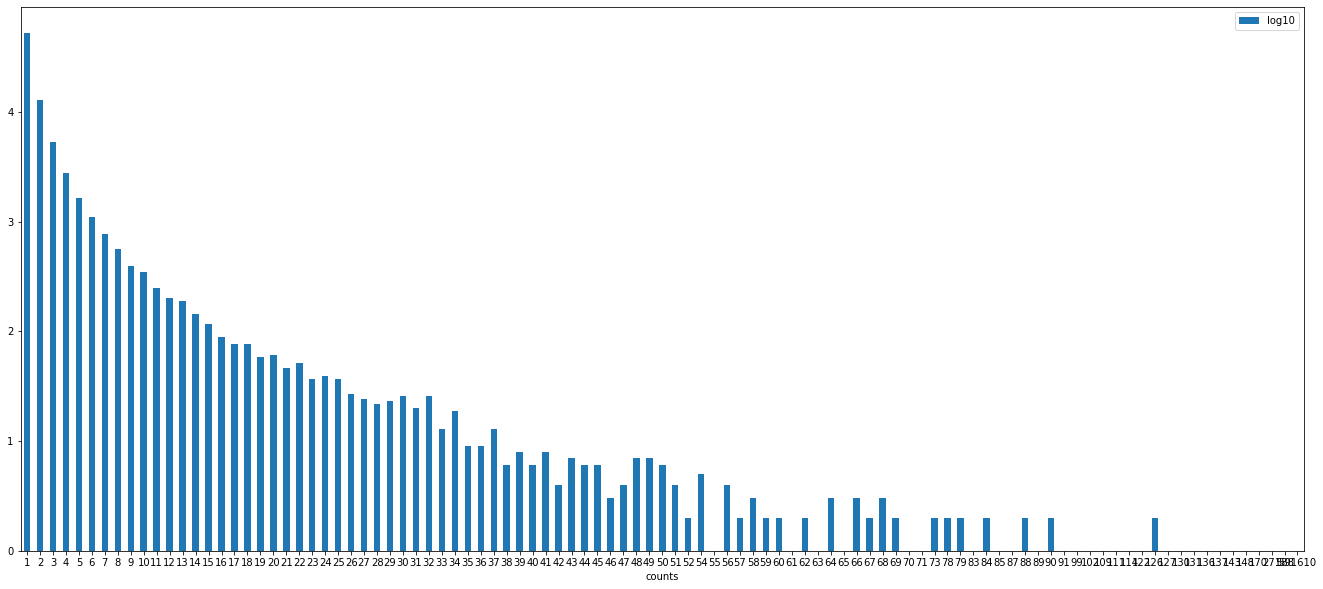

In [27]:
ax = count_df.plot.bar(y='log10', rot=0, figsize=(23,10))
plt.show()

### creatings duplicate pairs

In [28]:
pairs = []

In [29]:
for i in tqdm(range(1, value_counts_df.shape[0])):
    
    details = value_counts_df.iloc[i, :]
    
    bug_ids = set()
    dup_id = details['unique_values']
    bug_ids.add(dup_id)
    
    #find all the bugs that contain this dup_id
    bug_id_df = df.loc[df['dup_id'] == str(dup_id)]
    if not bug_id_df.empty:
        for row in bug_id_df.iterrows():
            details_row = row[1]
            bug_ids.add(details_row['bug_id'])
    
    pairs_list = combinations(bug_ids, 2)
    pairs.extend(pairs_list)

100%|█████████████████████████████████████| 79871/79871 [55:41<00:00, 23.90it/s]


In [30]:
len(pairs)

1149116

In [ ]:
pairs[:][0]

In [ ]:
duplicate_df = pd.DataFrame(pairs, columns=["bug1", "bug2"])

In [ ]:
duplicate_df.to_csv('./duplicate_bug_pairs.csv' ,index=False)

### creating non duplicate bug pairs 

In [7]:
list_of_non_dup_bugs = []

In [8]:
#find list of all bugs where dup_id is empty
for i in tqdm(range(df.shape[0])):
    details = df.iloc[i, :]
    bug_idx = details['bug_id']
    dup_idx = details['dup_id']
     
    if dup_idx == '[]':
        list_of_non_dup_bugs.append(bug_idx)

100%|█████████████████████████████████| 768335/768335 [01:28<00:00, 8667.24it/s]


In [9]:
len(list_of_non_dup_bugs)

591610

In [10]:
#creating all pairs

all_nd_pairs = combinations(list_of_non_dup_bugs, 2)

#creating 4 time non dup pairs

In [15]:
non_dup_df = pd.DataFrame(columns=['bug1', 'bug2'])
non_dup_df

,bug1,bug2


In [16]:
for pair in tqdm(all_nd_pairs):
    
    series_obj = pd.Series(pair, 
                        index=non_dup_df.columns )

# Add a series as a row to the dataframe  
    non_dup_df = non_dup_df.append(  series_obj,
                        ignore_index=True)   

720797it [1:55:35, 103.92it/s]


KeyboardInterrupt: 

In [17]:
non_dup_df.shape

(720797, 2)

In [18]:
non_dup_df.to_csv('./non_duplicate_bug_pairs.csv' ,index=False)